In [ ]:
import os, sys
from pathlib import Path

_root = next((p for p in [Path(os.getcwd()), *Path(os.getcwd()).parents]
              if p.name == 'cryptoTrading2'), None)
if _root:
    os.chdir(str(_root))
if os.getcwd() not in sys.path:
    sys.path.insert(0, os.getcwd())

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import pickle
import warnings
warnings.filterwarnings('ignore')

from files.functions import (
    dataSetup,
    fullDataPath,
    _arima_grid_search,
    _standardized_rmse,
    _save_model_artifact,
    _save_metrics,
    generate_future_index,
)
from files.CONSTANTS import COIN, RESPONSE_VARIABLE, TRAINING_COLUMNS, TEST_DAYS, TRAIN_PCT
from files.functions import *
from implementations.arima_model import ARIMAModel

# ARIMA Training

Univariate AutoRegressive Integrated Moving Average (ARIMA) model for crypto price prediction.
This notebook uses only the price/response series and tunes the `(p, d, q)` order by minimizing AIC
on the training split. Rolling one-step-ahead predictions are used for validation.
The final model is re-trained on the full series before forecasting future prices.

Dataset shape: (730, 25)
Price series length: 730
Date range: 2024-02-24 00:00:00 → 2026-02-22 00:00:00


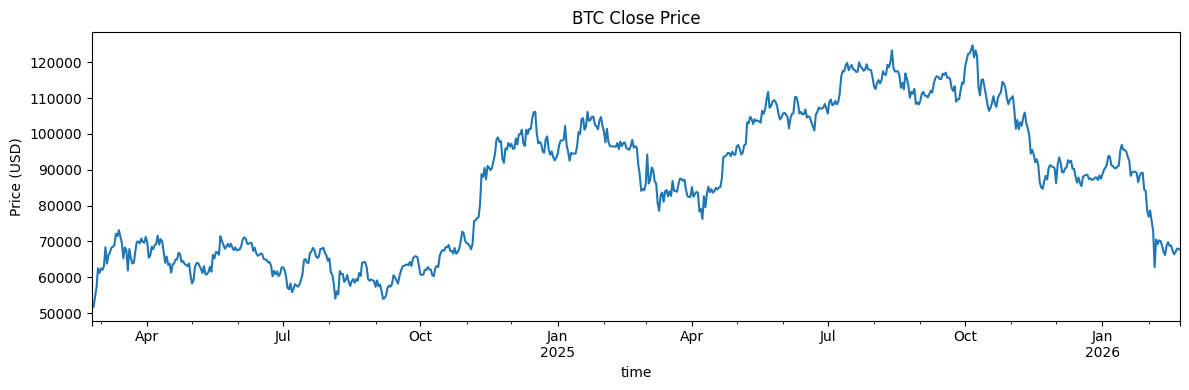


Train size: 584  |  Val size: 146


In [2]:
# ── Step 1: Load Data ────────────────────────────────────────────────────────
raw_path = fullDataPath(COIN)
data = pd.read_csv(raw_path)
daily_data = dataSetup(data, trainingColPath=TRAINING_COLUMNS, response=RESPONSE_VARIABLE, number=LIMIT)

# Extract univariate price series
price_series = daily_data[RESPONSE_VARIABLE].copy()
print(f"Dataset shape: {daily_data.shape}")
print(f"Price series length: {len(price_series)}")
print(f"Date range: {price_series.index[0]} → {price_series.index[-1]}")

price_series.plot(title=f"{COIN} Close Price", figsize=(12, 4))
plt.ylabel("Price (USD)")
plt.tight_layout()
plt.show()

# ── Step 2: Train / Validation Split ─────────────────────────────────────────
n = len(price_series)
split_idx = max(1, int(n * TRAIN_PCT))
train_series = price_series.iloc[:split_idx]
val_series = price_series.iloc[split_idx:]
print(f"\nTrain size: {len(train_series)}  |  Val size: {len(val_series)}")

In [3]:
# ── Step 3: Define Hyperparameter Grid ───────────────────────────────────────
# ARIMA(p, d, q): p = AR order, d = integration order, q = MA order
p_range = (0, 1, 2)   # AR lags to try
d_range = (0, 1)      # differencing orders to try
q_range = (0, 1, 2)   # MA lags to try

total_combos = len(p_range) * len(d_range) * len(q_range)
print(f"p_range: {p_range}")
print(f"d_range: {d_range}")
print(f"q_range: {q_range}")
print(f"Total (p,d,q) combinations: {total_combos}")

p_range: (0, 1, 2)
d_range: (0, 1)
q_range: (0, 1, 2)
Total (p,d,q) combinations: 18


In [4]:
# ── Step 4: Tune Hyperparameters — Grid Search by AIC ────────────────────────
print("Running ARIMA grid search (AIC-based)...")
best_order, tuning_df = _arima_grid_search(
    train_series, p_range=p_range, d_range=d_range, q_range=q_range
)

print(f"\nBest ARIMA order: {best_order}")

# Show top-5 results by AIC
print("\nTop-5 configurations by AIC:")
if not tuning_df.empty:
    print(tuning_df.head(5).to_string(index=False))

Running ARIMA grid search (AIC-based)...


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/Library/Frameworks/Python.frame


Best ARIMA order: (0, 1, 0)

Top-5 configurations by AIC:
 p  d  q          aic          bic
 0  1  0 10536.875893 10541.244080
 1  1  0 10536.915003 10545.651377
 0  1  1 10537.100924 10545.837298
 1  1  1 10538.017098 10551.121659
 2  1  0 10538.065709 10551.170271


In [5]:
# ── Step 5: Train Best Model on Training Series ───────────────────────────────
p, d, q = best_order
model = ARIMAModel(p, d, q)
model.fit(train_series)
print(f"ARIMA{best_order} fitted on training series ({len(train_series)} obs).")
print(f"AIC: {model.aic:.2f}  |  BIC: {model.bic:.2f}")

# Show model summary
print("\nModel Summary:")
print(model.summary())

ARIMA(0, 1, 0) fitted on training series (584 obs).
AIC: 10536.88  |  BIC: 10541.24

Model Summary:
                               SARIMAX Results                                
Dep. Variable:                  close   No. Observations:                  584
Model:                 ARIMA(0, 1, 0)   Log Likelihood               -5267.438
Date:                Sun, 22 Feb 2026   AIC                          10536.876
Time:                        19:53:31   BIC                          10541.244
Sample:                    02-24-2024   HQIC                         10538.579
                         - 09-29-2025                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
sigma2      4.117e+06   1.74e+05     23.616      0.000    3.77e+06    4.46e+06
Ljung-Box (L1) (Q):            

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


In [6]:
# ── Step 6: Save Model to models/{COIN}/ ─────────────────────────────────────
# First retrain on FULL series so saved model is ready for production forecasting
final_model = ARIMAModel(*best_order)
final_model.fit(price_series)
print(f"Final ARIMA{best_order} trained on full series ({len(price_series)} obs).")

artifact_path = _save_model_artifact(final_model, COIN, f'{COIN}_arima_model.pkl')
print(f"Model saved to: {artifact_path}")

Final ARIMA(0, 1, 0) trained on full series (730 obs).
Model saved to: /Users/sucheen/Documents/cryptoTrading2/models/BTC/BTC_arima_model.pkl


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


Running rolling one-step forecasts over 146 validation points...

Validation RMSE:            2,334.05
Standardized RMSE (÷ std):  0.1599


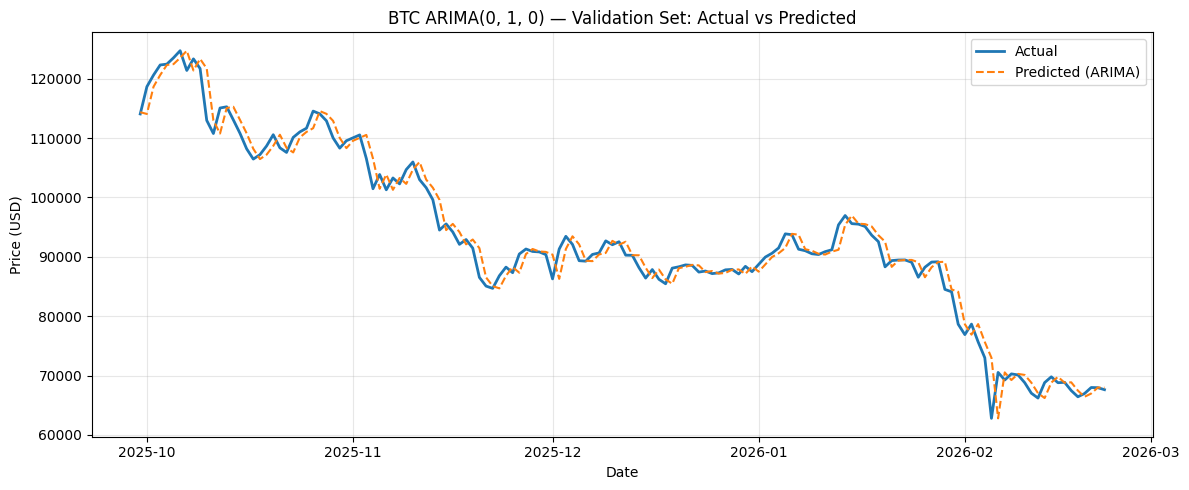

In [7]:
# ── Step 7: Predict on Validation Set (rolling one-step-ahead) ───────────────
from statsmodels.tsa.arima.model import ARIMA as _ARIMA

print(f"Running rolling one-step forecasts over {len(val_series)} validation points...")
val_preds_list = []
history = train_series.tolist()
for actual in val_series:
    tmp = _ARIMA(history, order=best_order).fit()
    val_preds_list.append(float(tmp.forecast(steps=1)[0]))
    history.append(actual)

val_preds = np.array(val_preds_list)
val_df = pd.DataFrame({'predicted_price': val_preds}, index=val_series.index)

# Compute RMSE
rmse, std_rmse = _standardized_rmse(val_series, val_preds)
print(f"\nValidation RMSE:            {rmse:,.2f}")
print(f"Standardized RMSE (÷ std):  {std_rmse:.4f}")

# Save RMSE


# Plot actual vs predicted
fig, ax = plt.subplots(figsize=(12, 5))
ax.plot(val_series.index, val_series.values, label='Actual', linewidth=2)
ax.plot(val_df.index, val_df['predicted_price'], label='Predicted (ARIMA)', linestyle='--')
ax.set_title(f"{COIN} ARIMA{best_order} — Validation Set: Actual vs Predicted")
ax.set_xlabel("Date")
ax.set_ylabel("Price (USD)")
ax.legend()
ax.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

Future predictions for next 7 days:
            predicted_price
2026-02-23         67617.98
2026-02-24         67617.98
2026-02-25         67617.98
2026-02-26         67617.98
2026-02-27         67617.98
2026-02-28         67617.98
2026-03-01         67617.98


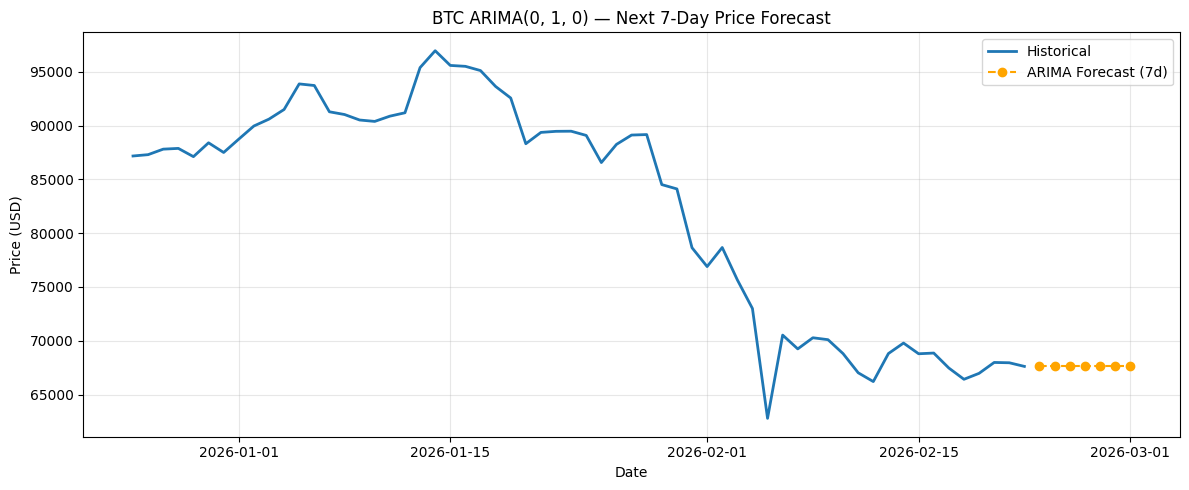

In [8]:
# ── Step 8: Predict Next TEST_DAYS Days ──────────────────────────────────────
# final_model was already trained on the full price_series (Step 6)
forecast_vals = final_model.forecast(steps=TEST_DAYS)
future_index = generate_future_index(daily_data.index[-1], TEST_DAYS)
future_df = pd.DataFrame({'predicted_price': forecast_vals}, index=future_index)

print(f"Future predictions for next {TEST_DAYS} days:")
print(future_df.to_string())

# Plot future forecast
fig, ax = plt.subplots(figsize=(12, 5))
hist = price_series.iloc[-60:]
ax.plot(hist.index, hist.values, label='Historical', linewidth=2)
ax.plot(future_df.index, future_df['predicted_price'], marker='o',
        linestyle='--', label=f'ARIMA Forecast ({TEST_DAYS}d)', color='orange')
ax.set_title(f"{COIN} ARIMA{best_order} — Next {TEST_DAYS}-Day Price Forecast")
ax.set_xlabel("Date")
ax.set_ylabel("Price (USD)")
ax.legend()
ax.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

In [ ]:
# ── Step 9: Save Metrics ──────────────────────────────────────────────────────
metrics_path = _save_metrics(std_rmse, COIN, 'arima')

print(f"Metrics (std RMSE) saved to: {metrics_path}")
print(f"\nStandardized RMSE: {std_rmse:.4f}")
print("Done.")